# 利用ResNet50网络进行ImageNet分类
    tf.keras.applications.ResNet50(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=None,
        pooling=None,
        classes=1000
    )

##### 测试数据集 ImageNet
    /home/hjw/e/dataset_tiptical/image_net
#### 实验内容
* 加载模型
* 测试ImageNet测试集
* 把测试结果保存为h5文件

In [29]:
import os
import numpy as np
import h5py
import tensorflow as tf
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from mylibs.data.ImageNetData import ImageNetData

train_dir='%s/e/dataset_tiptical/image_net/ILSVRC2012_img_train'%os.getenv('HOME')#训练文件夹
val_dir  ='%s/e/dataset_tiptical/image_net/ILSVRC2012_img_val'%os.getenv('HOME')  #校验文件夹
test_dir ='%s/e/dataset_tiptical/image_net/ILSVRC2012_img_test'%os.getenv('HOME') #测试文件夹
imageNet_data_path='%s/e/dataset_tiptical/image_net/ILSVRC2012_devkit_t12/data'%os.getenv('HOME') #ImageNetData
model_file='%s/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels.h5'%os.getenv('HOME')    #模型文件
#预测结果存放文件
data_file='%s/work/data/predict_val/imagenet_test-resnet50_weights_tf_dim_ordering_tf_kernels.h5'%os.getenv('HOME')
#软链接输出目录
to_path  ='%s/work/temp/predict_val_imagenet/ResNet50'%os.getenv('HOME')

## 加载模型

In [11]:
from keras.applications.resnet50 import ResNet50
model=ResNet50(weights=model_file)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## 加载ImageNetData信息

In [8]:
from mylibs.data.ImageNetData import ImageNetData
dataInfo=ImageNetData(imageNet_data_path)

## ImageNet测试数据集

In [27]:
#ImageNet测试数据集
import os
import h5py
from keras.preprocessing import image
from mylibs.ProcessBar import ShowProcess
pb = ShowProcess(100,'','', 'OK') #进度条

#逐个文件测试
items=os.listdir(test_dir)
count=len(items)
files=[]    #文件列表
predicts=[] #预测结果
for i,sfile in enumerate(items):
    img_path=os.path.join(test_dir,sfile)                      #图像完整路径
    if not os.path.isdir(img_path):
        img = image.load_img(img_path, target_size=(224, 224)) #加载图像
        x = image.img_to_array(img)    #to_array
        x = np.expand_dims(x, axis=0)  #扩展batch_size维度
        x = preprocess_input(x)        #图像预处理
        preds = model.predict(x)       #模型预测
        #print('Predicted:', decode_predictions(preds, top=3)[0])
        top3=decode_predictions(preds,top=3)[0] #解码top3结果
        #top3结果转换为3x2数组，第一列为预测ID，第二列为置信度;第一行至第三行分别为top1,2,3
        data=np.zeros((3,2),dtype=np.float32)
        for j in range(3):
            wnid=top3[j][0]
            f_info=dataInfo.get_info_from_wnid(wnid)
            data[j,0]=f_info['ID']
            data[j,1]=top3[j][2]
        #文件序列
        files.append(sfile)
        #预测结果序列
        predicts.append(data)
        if i % 10 == 0:
            pb.show_process(int(i*100.0/count),infoTail='%d/%d'%(i,count))
pb.show_process(100)

#=========保存预测结果===========
if os.path.exists(data_file):
    print('%s already exists,please delete first!'%(data_file))
else:
    #创建文件
    f=h5py.File(data_file,'w') 
    #图像文件序列
    dt_str = h5py.special_dtype(vlen=str) 
    data = np.array(files)
    ds = f.create_dataset('files', data.shape , dtype=dt_str,compression='gzip') 
    ds[:] = data
    #图像预测结果
    f.create_dataset('predicts',data=predicts,compression='gzip')
    #关闭文件
    f.close()

    #读取测试
    f=h5py.File(data_file,'r')
    files2=np.array(f['files'])
    predicts=np.array(f['predicts'])
    print(len(files))
    print(predicts.shape)
    print(files[0])
    print(predicts[0])
    f.close()

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]99990/100000
OK
100000
(100000, 3, 2)
ILSVRC2012_test_00068168.JPEG
[[3.5600000e+02 4.0449023e-01]
 [5.0400000e+02 1.7412442e-01]
 [5.3100000e+02 7.3170513e-02]]


## 创建预测结果的软链接目录

In [30]:
#预测结果转化
'''
把预测结果通过软链接输出到指定目录
'''
import os
import h5py
from mylibs.ProcessBar import ShowProcess
from mylibs.data.ImageNetData import ImageNetData
from mylibs.ProcessBar import ShowProcess

#加载ImageNetData信息
print('load ImageNetData info......')
imageNetInfo=ImageNetData(imageNet_data_path)      #加载ImageNetData
print('load ImageNetData info finished!')

#加载预测结果
print('load predicts file ......')
f=h5py.File(data_file,'r')
files=np.array(f['files'])
predicts=np.array(f['predicts'])
f.close()
print('load predicts file finished!')

#进度条
print('create symlinks ......')
pb = ShowProcess(100,'','', 'OK') 
count=len(files)
#创建软链接
for i,sfile in enumerate(files):
    ID=int(predicts[i][0,0])
    f_info=imageNetInfo.get_info_from_id(ID)
    if f_info != None:
        src='%s/%s'%(test_dir,sfile)
        dst_path='%s/%s_%s'%(to_path,f_info['WNID'],f_info['cn_name'])
        dst='%s/%s'%(dst_path,sfile)
        os.makedirs(dst_path) if not os.path.exists(dst_path) else ''
        os.symlink(src,dst)
        if i % 20 == 0:
            pb.show_process(int(i*100./count),'','%d/%d'%(i,count))
pb.show_process(100)
print('create symlinks finished!')

print('Done!') 

load ImageNetData info......
load ImageNetData info finished!
load predicts file ......
load predicts file finished!
create symlinks ......
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]99980/100000
OK
create symlinks finished!
Done!


## 预测指定文件序列

In [ ]:
from mylibs.data.ImageNetData import ImageNetData
imageNetInfo=ImageNetData(imageNet_data_path)      #加载ImageNetData

[n01440764_18]_1_n01440764_丁鲷


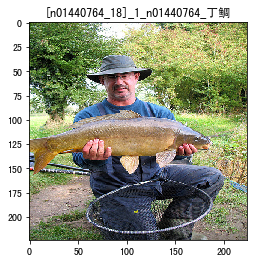

[n01440764_36]_1_n01440764_丁鲷


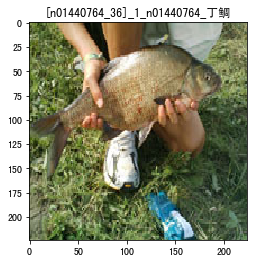

[n01440764_37]_1_n01440764_丁鲷


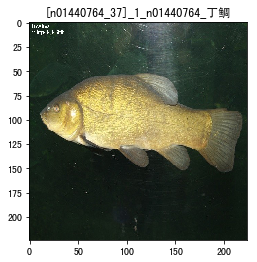

[n01440764_44]_1_n01440764_丁鲷


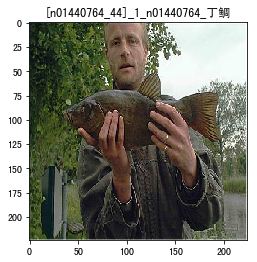

In [33]:
#ImageNet测试数据集
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

test_dir ='%s/e/dataset_tiptical/image_net/ILSVRC2012_img_test'%os.getenv('HOME') #测试图像目录
files_id=['00000002','00000003','00000004','00000005','00000006','00000007','00000008','00000009'] #测试图像ID
prefix='ILSVRC2012_test'

test_dir='%s/e/dataset_tiptical/image_net/ILSVRC2012_img_train/n01440764'%os.getenv('HOME')
files_id=['18','36','37','44']
prefix='n01440764'

#逐个文件测试
predicts={} #预测结果
for ID in files_id:
    sfile='%s/%s_%s.JPEG'%(test_dir,prefix,ID)
    img = image.load_img(sfile, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    y = model.predict(x)
    preds = model.predict(x)       #模型预测
    #print('Predicted:', decode_predictions(preds, top=3)[0])
    top3=decode_predictions(preds,top=3)[0] #解码top3结果
    wnid=top3[0][0]
    f_info=imageNetInfo.get_info_from_wnid(wnid)
    if f_info!=None:
        title='[%s_%s]_%d_%s_%s'%(prefix,ID,y_id[0],f_info['WNID'],f_info['cn_name'])
        print(title)
        plt.figure
        plt.imshow(img)
        plt.title(title)  
        plt.show()
